In [3]:
%matplotlib inline
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

def generate_real():
    real_data = torch.FloatTensor([random.uniform(0.8, 1.0),
                                   random.uniform(0.0, 0.2),
                                   random.uniform(0.8, 1.0),
                                   random.uniform(0.0, 0.2)])
    return real_data

# generate_real()

def generate_random(size):
    random_data = torch.rand(size)
    return random_data

class Discriminator(nn.Module):
    def __init__(self):
        ## Pytorch 부모 클래스 초기화
        super().__init__()
        
        ## 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(4, 3),
            nn.Sigmoid(),
            nn.Linear(3, 1),
            nn.Sigmoid()
        )
        
        ## 손실함수 설정
        self.loss_function = nn.MSELoss()
        
        ## SGD 옵티마이저 설정
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        ## 진행 측정을 위한 변수 초기화
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        ## 모델 실행
        return self.model(inputs)
    
    def train(self, inputs, targets):
        ## 신경망 출력 계산
        outputs = self.forward(inputs)
        
        ## 손실 계산
        loss = self.loss_function(outputs, targets)
        
        ## 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        if self.counter % 10000 == 0:
            print("counter :", self.counter)
        
        ## 기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))


counter : 10000
counter : 20000
0.7541272640228271
0.1637694388628006


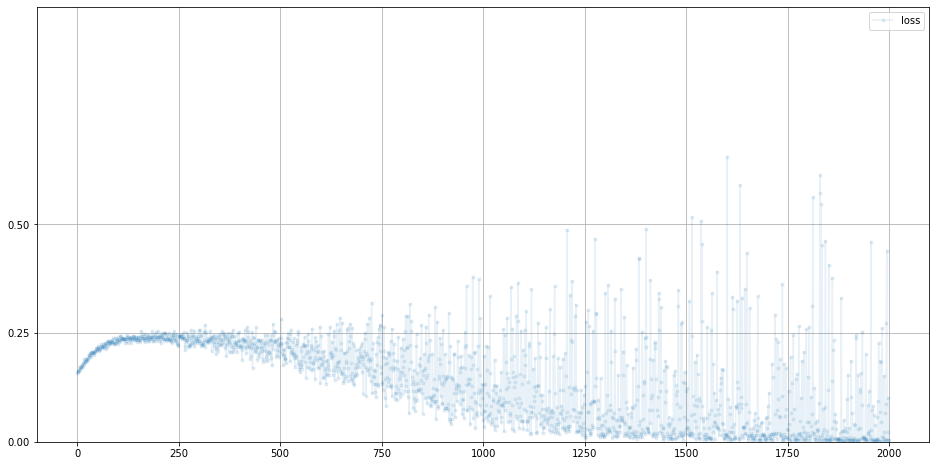

In [4]:
D = Discriminator()

for i in range(10000):
    ## 실제 데이터
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    ## 생성된 데이터
    D.train(generate_random(4), torch.FloatTensor([0.0]))
    
D.plot_progress()
print(D.forward(generate_real()).item())
print(D.forward(generate_random(4)).item())

In [8]:
class Generator(nn.Module):
    def __init__(self):
        ## Pytorch 부모 클래스 초기화
        super().__init__()
        
        ## 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(1, 3),
            nn.Sigmoid(),
            nn.Linear(3, 4),
            nn.Sigmoid()
        )
        
        ## SGD 옵티마이저 설정
        self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)
        
        ## 진행 측정을 위한 변수 초기화
        self.counter = 0
        self.progress = []
        
    def forward(self, inputs):
        ## 모델 실행
        return self.model(inputs)
    
    def train(self, D, inputs, targets):
        ## 신경망 출력 계산
        g_outputs = self.forward(inputs)
        
        ## 판별기로 전달
        d_outputs = D.forward(g_outputs)
        
        ## 오차 계산
        loss = D.loss_function(d_outputs, targets)
        
        ## 카운터를 증가시키고 10회마다 오차 저장
        self.counter += 1
        if self.counter % 10 == 0:
            self.progress.append(loss.item())
        
        ## 기울기를 초기화하고 역전파 후 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def plot_progress(self):
        df = pd.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16, 8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))        
        
G = Generator()
G.forward(torch.FloatTensor([0.5]))

tensor([0.4351, 0.6644, 0.5774, 0.3730], grad_fn=<SigmoidBackward0>)

counter : 10000
counter : 20000
CPU times: user 6.83 s, sys: 0 ns, total: 6.83 s
Wall time: 6.83 s


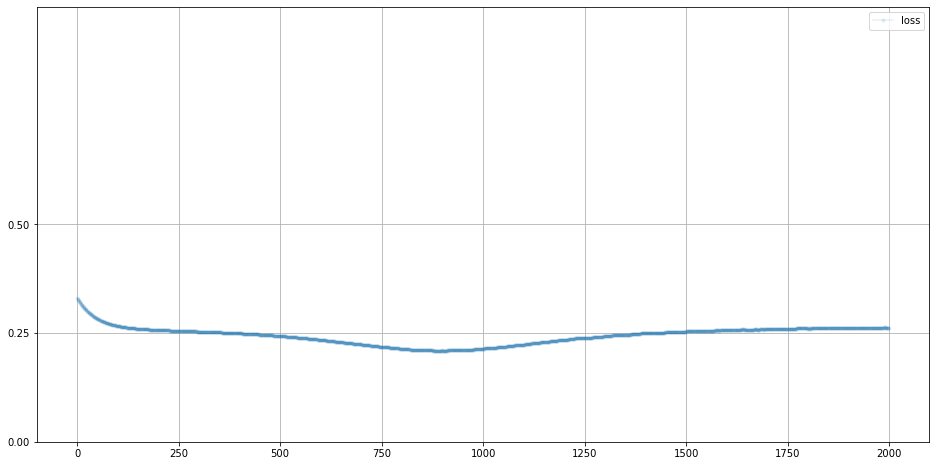

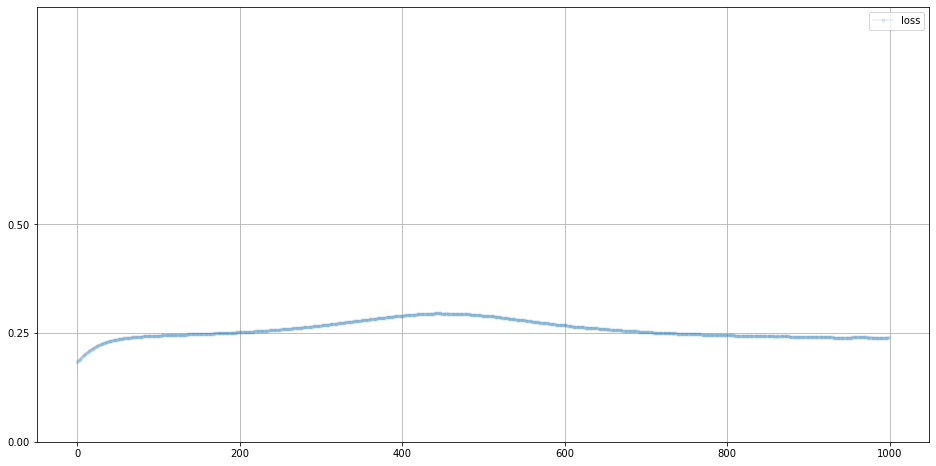

In [10]:
%%time
# GAN 훈련하기
## 판별기 및 생성기 생성
D = Discriminator()
G = Generator()

## 판별기와 생성기 훈련
image_list = []
for i in range(10000):
    ## 1단계: 참에 대해 판별기 훈련
    D.train(generate_real(), torch.FloatTensor([1.0]))
    
    ## 2단계: 거짓에 대해 판별기 훈련
    ## G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(torch.FloatTensor([0.5])).detach(), torch.FloatTensor([0.0]))
    
    ## 3단계: 생성기 훈련
    G.train(D, torch.FloatTensor([0.5]), torch.FloatTensor([1.0]))
    
    if i % 1000 == 0:
        image_list.append(G.forward(torch.FloatTensor[0.5]).detach().numpy())

D.plot_progress()
G.plot_progress()

In [21]:
G.forward(torch.FloatTensor([0.5]))

tensor([0.9494, 0.0388, 0.9259, 0.0570], grad_fn=<SigmoidBackward0>)